# Part 3: Validation

In [99]:
# %%capture
%pip install python-terrier

import pyterrier as pt
from pyterrier.measures import *
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm


from my_utils import query_similar_words
from my_utils import preprocess
pd.set_option('max_colwidth', 800)

Note: you may need to restart the kernel to use updated packages.


In [100]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-1.11.0-openjdk-amd64/"

if not pt.started():
  pt.init()

In [101]:
def create_index(docs_df, mode="both", indexer_path="./pd_index"):

    pd_indexer = pt.DFIndexer(indexer_path, remove_stopwords=False, overwrite=True)
    pd_indexer.setProperty("termpipelines", "")
    #pd_indexer.setProperty("metaindex.compressed.reverse.allow.duplicates", "False")

    if mode == "title":
        index_ref = pd_indexer.index(docs_df["title"], docs_df["docno"])
    elif mode == "abstract":
        index_ref = pd_indexer.index(docs_df["abstract"], docs_df["docno"])
    else:  # both or else
        index_ref = pd_indexer.index(docs_df["title"], docs_df["abstract"], docs_df["docno"])

    return index_ref

def index_model(index, model="TF_IDF"):
    """
    Create and return an indexing model.
    http://terrier.org/docs/current/javadoc/org/terrier/matching/models/package-summary.html
    Model can be such as:
    "TF_IDF", "PL2", "DLH",
    "Hiemstra_LM", "Dirichlet_LM",
    "BM25", etc
    """
    list_model = ["TF_IDF", "PL2", "DLH", "Hiemstra_LM", "Dirichlet_LM", "BM25"]

    indexing_model = pt.BatchRetrieve(index, wmodel=model)
    return indexing_model

def preprocess_queries(queries, augemented=False, mv_model=None):
    queries_preprocessed = queries.copy()
    for index, row in tqdm(queries.iterrows(), total=len(queries)):
        pre_processed_title = " ".join(preprocess(row["title"]))
        pre_processed_description = " ".join(preprocess(row["description"]))
        pre_processed_narrative = " ".join(preprocess(row["narrative"]))

        if augemented:
            pre_processed_title = query_similar_words(pre_processed_title, mv_model)
            pre_processed_description = query_similar_words(pre_processed_description, mv_model)
            pre_processed_narrative = query_similar_words(pre_processed_narrative, mv_model)

        queries_preprocessed.loc[index, "title"] = pre_processed_title
        queries_preprocessed.loc[index, "description"] = pre_processed_description
        queries_preprocessed.loc[index, "narrative"] = pre_processed_narrative

    if augemented:
        queries_preprocessed.to_pickle("data/queries_processed_aug.pkl")
    else:
        queries_preprocessed.to_pickle("data/queries_processed.pkl")

    return queries_preprocessed

def expirement(indexed_docs, preprocessed_query, qrels):
    tfidf = index_model(indexed_docs, model="TF_IDF")
    bm25 = index_model(indexed_docs, model="BM25")
    dirichlet_lm = index_model(indexed_docs, model="DirichletLM")

    exp = pt.Experiment(
        [tfidf, bm25, dirichlet_lm],
        preprocessed_query,
        qrels,
        eval_metrics=[P@5, P@10, nDCG@10, RR(rel=2)],
        names=["TF_IDF", "BM25", "DirichletLM"]
    )
    return exp

## Experiments
 - preprocessing: {all languages, only english}
 - topics: {title, description, narrative}
 - indexing: {title, abstract, both}
 - models: {tf_idf, bm25, dirichlet_lm}

In [102]:
# read preprocessed en documents
en_docs = pd.read_pickle('./data/en_docs_processed.pkl')
en_docs.rename(columns={"doc_id":"docno"}, inplace=True)

# read preprocessed documents
docs = pd.read_pickle('./data/docs_processed.pkl')
docs.rename(columns={"doc_id":"docno"}, inplace=True)

In [103]:
len(docs), len(en_docs)

(84195, 81823)

In [104]:
# check if there are newer versions of the documents after the last TREC-COVID release
sum(docs[(docs['date'] > '2020-07-16')].value_counts('docno') != 1) > 0

False

In [105]:
def keep_recent_versions(df):
    df.sort_values(by="date", ascending=False, inplace=True)
    df.drop_duplicates(subset=["docno"], inplace=True)
    return df

docs = keep_recent_versions(docs)
en_docs = keep_recent_versions(en_docs)

In [106]:
len(docs), len(en_docs)

(83159, 80847)

In [ ]:
%%capture

# index en-documents by (title, abstract, both)
index_ref_en_docs_title = create_index(en_docs, mode="title", indexer_path="./indexes/en/title")
index_en_docs_title = pt.IndexFactory.of(index_ref_en_docs_title)

index_ref_en_docs_abstract = create_index(en_docs, mode="abstract", indexer_path="./indexes/en/abstract")
index_en_docs_abstract = pt.IndexFactory.of(index_ref_en_docs_abstract)

index_ref_en_docs_both = create_index(en_docs, mode="both", indexer_path="./indexes/en/both")
index_en_docs_both = pt.IndexFactory.of(index_ref_en_docs_both)

In [ ]:
%%capture

# index documents by (title, abstract, both)
index_ref_docs_title = create_index(docs, mode="title", indexer_path="./indexes/all/title")
index_docs_title = pt.IndexFactory.of(index_ref_docs_title)

index_ref_docs_abstract = create_index(docs, mode="abstract", indexer_path="./indexes/all/abstract")
index_docs_abstract = pt.IndexFactory.of(index_ref_docs_abstract)

index_ref_docs_both = create_index(docs, mode="both", indexer_path="./indexes/all/both")
index_docs_both = pt.IndexFactory.of(index_ref_docs_both)

In [109]:
pd.set_option('max_colwidth', 800)
#preprocess queries by (title, description, narrative)
import ir_datasets
dataset = ir_datasets.load("cord19/trec-covid")
queries = pd.DataFrame(dataset.queries_iter())
queries = preprocess_queries(queries, augemented=False, mv_model=None)
display(queries.head(5))

pq_title = queries[['query_id', 'title']]
pq_title = pq_title.rename(columns={'query_id':'qid', 'title':'query'})
display(pq_title.head(5))

pq_desc = queries[['query_id', 'description']]
pq_desc = pq_desc.rename(columns={'query_id':'qid', 'description':'query'})
display(pq_desc.head(5))

pq_narr = queries[['query_id', 'narrative']]
pq_narr = pq_narr.rename(columns={'query_id':'qid', 'narrative':'query'})
display(pq_narr.head(5))

  0%|          | 0/50 [00:00<?, ?it/s]

,query_id,title,description,narrative
0,1,coronavirus origin,origin covid19,seek range information sarscov2 virus origin include evolution animal source first transmission human
1,2,coronavirus response weather change,coronavirus respond change weather,seek range information sarscov2 virus viability different weatherclimate condition well information relate transmission virus different climate condition
2,3,coronavirus immunity,sarscov2 infect people develop immunity cross protection possible,seek study immunity develop due infection sarscov2 cross protection gain due infection coronavirus type
3,4,people die coronavirus,cause death covid19,study look mechanism death covid19
4,5,animal model covid19,drug active sarscov sarscov2 animal study,paper describe result test drug bind spike protein virus drug animal model paper sarscov2 infection cell culture assay also relevant


,qid,query
0,1,coronavirus origin
1,2,coronavirus response weather change
2,3,coronavirus immunity
3,4,people die coronavirus
4,5,animal model covid19


,qid,query
0,1,origin covid19
1,2,coronavirus respond change weather
2,3,sarscov2 infect people develop immunity cross protection possible
3,4,cause death covid19
4,5,drug active sarscov sarscov2 animal study


,qid,query
0,1,seek range information sarscov2 virus origin include evolution animal source first transmission human
1,2,seek range information sarscov2 virus viability different weatherclimate condition well information relate transmission virus different climate condition
2,3,seek study immunity develop due infection sarscov2 cross protection gain due infection coronavirus type
3,4,study look mechanism death covid19
4,5,paper describe result test drug bind spike protein virus drug animal model paper sarscov2 infection cell culture assay also relevant


In [110]:
# load trec-covid dataset
cord19 = pt.get_dataset("irds:cord19/trec-covid")
qrels = cord19.get_qrels()

In [111]:
# en_docs {title, abstract, both} with query_title
exp1 = expirement(index_en_docs_title, pq_title, qrels)
display(exp1)

exp2 = expirement(index_en_docs_abstract, pq_title, qrels)
display(exp2)

exp3 = expirement(index_en_docs_both, pq_title, qrels)
display(exp3)

# en_docs {title, abstract, both} with query_description
exp4 = expirement(index_en_docs_title, pq_desc, qrels)
display(exp4)

exp5 = expirement(index_en_docs_abstract, pq_desc, qrels)
display(exp5)

exp6 = expirement(index_en_docs_both, pq_desc, qrels)
display(exp6)

# en_docs {title, abstract, both} with query_narrative
exp7 = expirement(index_en_docs_title, pq_narr, qrels)
display(exp7)

exp8 = expirement(index_en_docs_abstract, pq_narr, qrels)
display(exp8)

exp9 = expirement(index_en_docs_both, pq_narr, qrels)
display(exp9)

,name,P@5,P@10,nDCG@10,RR(rel=2)
0,TF_IDF,0.572,0.562,0.521739,0.622446
1,BM25,0.576,0.550,0.512641,0.615589
2,DirichletLM,0.540,0.508,0.468562,0.551330


,name,P@5,P@10,nDCG@10,RR(rel=2)
0,TF_IDF,0.732,0.688,0.633095,0.724063
1,BM25,0.668,0.648,0.589952,0.700447
2,DirichletLM,0.676,0.670,0.594187,0.591624


,name,P@5,P@10,nDCG@10,RR(rel=2)
0,TF_IDF,0.624,0.586,0.552496,0.657000
1,BM25,0.632,0.578,0.543770,0.645228
2,DirichletLM,0.564,0.540,0.495286,0.599225


,name,P@5,P@10,nDCG@10,RR(rel=2)
0,TF_IDF,0.632,0.546,0.535381,0.671064
1,BM25,0.636,0.548,0.520960,0.611938
2,DirichletLM,0.440,0.428,0.395899,0.489001


,name,P@5,P@10,nDCG@10,RR(rel=2)
0,TF_IDF,0.736,0.70,0.644823,0.784202
1,BM25,0.676,0.64,0.566200,0.633944
2,DirichletLM,0.696,0.66,0.610008,0.685928


,name,P@5,P@10,nDCG@10,RR(rel=2)
0,TF_IDF,0.648,0.576,0.554599,0.675530
1,BM25,0.652,0.564,0.545502,0.673774
2,DirichletLM,0.496,0.458,0.417565,0.511969


,name,P@5,P@10,nDCG@10,RR(rel=2)
0,TF_IDF,0.468,0.418,0.381715,0.486482
1,BM25,0.448,0.432,0.386476,0.477303
2,DirichletLM,0.248,0.226,0.213624,0.337663


,name,P@5,P@10,nDCG@10,RR(rel=2)
0,TF_IDF,0.584,0.574,0.519124,0.602461
1,BM25,0.548,0.548,0.493708,0.614169
2,DirichletLM,0.436,0.436,0.387638,0.506611


,name,P@5,P@10,nDCG@10,RR(rel=2)
0,TF_IDF,0.480,0.426,0.399389,0.528925
1,BM25,0.480,0.432,0.405134,0.535337
2,DirichletLM,0.244,0.206,0.200178,0.322545


In [112]:
# docs {title, abstract, both} with query_title
exp1 = expirement(index_docs_title, pq_title, qrels)
display(exp1)

exp2 = expirement(index_docs_abstract, pq_title, qrels)
display(exp2)

exp3 = expirement(index_docs_both, pq_title, qrels)
display(exp3)

# docs {title, abstract, both} with query_description
exp4 = expirement(index_docs_title, pq_desc, qrels)
display(exp4)

exp5 = expirement(index_docs_abstract, pq_desc, qrels)
display(exp5)

exp6 = expirement(index_docs_both, pq_desc, qrels)
display(exp6)

# docs {title, abstract, both} with query_narrative
exp7 = expirement(index_docs_title, pq_narr, qrels)
display(exp7)

exp8 = expirement(index_docs_abstract, pq_narr, qrels)
display(exp8)

exp9 = expirement(index_docs_both, pq_narr, qrels)
display(exp9)

,name,P@5,P@10,nDCG@10,RR(rel=2)
0,TF_IDF,0.572,0.564,0.523648,0.622441
1,BM25,0.576,0.548,0.511069,0.615557
2,DirichletLM,0.524,0.502,0.460846,0.547692


,name,P@5,P@10,nDCG@10,RR(rel=2)
0,TF_IDF,0.732,0.692,0.634998,0.724053
1,BM25,0.664,0.646,0.589287,0.695181
2,DirichletLM,0.672,0.664,0.590112,0.590859


,name,P@5,P@10,nDCG@10,RR(rel=2)
0,TF_IDF,0.620,0.580,0.548256,0.656998
1,BM25,0.628,0.574,0.540893,0.645207
2,DirichletLM,0.564,0.540,0.495286,0.599223


,name,P@5,P@10,nDCG@10,RR(rel=2)
0,TF_IDF,0.632,0.546,0.535381,0.670968
1,BM25,0.636,0.548,0.520810,0.610791
2,DirichletLM,0.440,0.426,0.394819,0.488832


,name,P@5,P@10,nDCG@10,RR(rel=2)
0,TF_IDF,0.736,0.700,0.644396,0.784202
1,BM25,0.680,0.642,0.567955,0.633944
2,DirichletLM,0.692,0.658,0.607796,0.675928


,name,P@5,P@10,nDCG@10,RR(rel=2)
0,TF_IDF,0.648,0.576,0.554443,0.675530
1,BM25,0.656,0.564,0.545712,0.673496
2,DirichletLM,0.496,0.458,0.417476,0.511969


,name,P@5,P@10,nDCG@10,RR(rel=2)
0,TF_IDF,0.456,0.418,0.378497,0.472017
1,BM25,0.448,0.430,0.383058,0.474036
2,DirichletLM,0.256,0.224,0.214163,0.342773


,name,P@5,P@10,nDCG@10,RR(rel=2)
0,TF_IDF,0.584,0.574,0.519034,0.602448
1,BM25,0.552,0.548,0.493880,0.614167
2,DirichletLM,0.432,0.432,0.384271,0.506665


,name,P@5,P@10,nDCG@10,RR(rel=2)
0,TF_IDF,0.480,0.426,0.399389,0.528927
1,BM25,0.476,0.432,0.404772,0.535345
2,DirichletLM,0.244,0.208,0.202026,0.322534


## Query Expansion

In [115]:
AUGMENTED = True
if AUGMENTED:
    from gensim.models import Word2Vec
    mv_model = Word2Vec.load("data/word2vec.model")

dataset = ir_datasets.load("cord19/trec-covid")
queries = pd.DataFrame(dataset.queries_iter())
queries = preprocess_queries(queries, augemented=True, mv_model=mv_model)
display(queries.head(5))

pq_title = queries[['query_id', 'title']]
pq_title = pq_title.rename(columns={'query_id':'qid', 'title':'query'})
display(pq_title.head(5))

pq_desc = queries[['query_id', 'description']]
pq_desc = pq_desc.rename(columns={'query_id':'qid', 'description':'query'})
display(pq_desc.head(5))

pq_narr = queries[['query_id', 'narrative']]
pq_narr = pq_narr.rename(columns={'query_id':'qid', 'narrative':'query'})
display(pq_narr.head(5))

  0%|          | 0/50 [00:00<?, ?it/s]

,query_id,title,description,narrative
0,1,coronavirus 2019 origin origination,origin origination covid19 coronavirus,seek wary range interquartile information distill sarscov2 covid19 virus viral origin origination include included evolution evolutionary animal domesticate source information first 7755 transmission aerosolsborne human diseaserelevant
1,2,coronavirus 2019 response commentary weather meteorological change forcing,coronavirus 2019 respond ghdemphnet change forcing weather meteorological,seek wary range interquartile information distill sarscov2 covid19 virus viral viability pasteurization different various weatherclimate condition preexist well also information distill relate related transmission aerosolsborne virus viral different various climate climatological condition preexist
2,3,coronavirus 2019 immunity vaccineinduced,sarscov2 covid19 infect infected people individual develop developed immunity vaccineinduced cross sectional protection protective possible potential,seek wary study prospective immunity vaccineinduced develop developed due cause infection disease sarscov2 covid19 cross sectional protection protective gain operandi due cause infection disease coronavirus 2019 type blockerbased
3,4,people individual die studie coronavirus 2019,cause provokes death deaths covid19 coronavirus,study prospective look covid19what mechanism mechanisms death deaths covid19 coronavirus
4,5,animal domesticate model compartmental covid19 coronavirus,drug repurposing active dayuanyin sarscov sars sarscov2 covid19 animal domesticate study prospective,paper addressing describe present result study test testing drug repurposing bind affinity spike glycoprotein protein spike virus viral drug repurposing animal domesticate model compartmental paper addressing sarscov2 covid19 infection disease cell epithelial culture e6 assay covid19rdrphel also furthermore relevant detract


,qid,query
0,1,coronavirus 2019 origin origination
1,2,coronavirus 2019 response commentary weather meteorological change forcing
2,3,coronavirus 2019 immunity vaccineinduced
3,4,people individual die studie coronavirus 2019
4,5,animal domesticate model compartmental covid19 coronavirus


,qid,query
0,1,origin origination covid19 coronavirus
1,2,coronavirus 2019 respond ghdemphnet change forcing weather meteorological
2,3,sarscov2 covid19 infect infected people individual develop developed immunity vaccineinduced cross sectional protection protective possible potential
3,4,cause provokes death deaths covid19 coronavirus
4,5,drug repurposing active dayuanyin sarscov sars sarscov2 covid19 animal domesticate study prospective


,qid,query
0,1,seek wary range interquartile information distill sarscov2 covid19 virus viral origin origination include included evolution evolutionary animal domesticate source information first 7755 transmission aerosolsborne human diseaserelevant
1,2,seek wary range interquartile information distill sarscov2 covid19 virus viral viability pasteurization different various weatherclimate condition preexist well also information distill relate related transmission aerosolsborne virus viral different various climate climatological condition preexist
2,3,seek wary study prospective immunity vaccineinduced develop developed due cause infection disease sarscov2 covid19 cross sectional protection protective gain operandi due cause infection disease coronavirus 2019 type blockerbased
3,4,study prospective look covid19what mechanism mechanisms death deaths covid19 coronavirus
4,5,paper addressing describe present result study test testing drug repurposing bind affinity spike glycoprotein protein spike virus viral drug repurposing animal domesticate model compartmental paper addressing sarscov2 covid19 infection disease cell epithelial culture e6 assay covid19rdrphel also furthermore relevant detract


In [116]:
# en_docs {title, abstract, both} with query_title
exp1 = expirement(index_en_docs_title, pq_title, qrels)
display(exp1)

exp2 = expirement(index_en_docs_abstract, pq_title, qrels)
display(exp2)

exp3 = expirement(index_en_docs_both, pq_title, qrels)
display(exp3)

# en_docs {title, abstract, both} with query_description
exp4 = expirement(index_en_docs_title, pq_desc, qrels)
display(exp4)

exp5 = expirement(index_en_docs_abstract, pq_desc, qrels)
display(exp5)

exp6 = expirement(index_en_docs_both, pq_desc, qrels)
display(exp6)

# en_docs {title, abstract, both} with query_narrative
exp7 = expirement(index_en_docs_title, pq_narr, qrels)
display(exp7)

exp8 = expirement(index_en_docs_abstract, pq_narr, qrels)
display(exp8)

exp9 = expirement(index_en_docs_both, pq_narr, qrels)
display(exp9)

,name,P@5,P@10,nDCG@10,RR(rel=2)
0,TF_IDF,0.532,0.494,0.452778,0.535714
1,BM25,0.544,0.500,0.453458,0.519733
2,DirichletLM,0.448,0.450,0.399052,0.471594


,name,P@5,P@10,nDCG@10,RR(rel=2)
0,TF_IDF,0.548,0.524,0.466770,0.561011
1,BM25,0.528,0.520,0.467649,0.566811
2,DirichletLM,0.484,0.506,0.454407,0.592929


,name,P@5,P@10,nDCG@10,RR(rel=2)
0,TF_IDF,0.564,0.522,0.475555,0.531976
1,BM25,0.576,0.530,0.479270,0.521706
2,DirichletLM,0.508,0.482,0.435032,0.514882


,name,P@5,P@10,nDCG@10,RR(rel=2)
0,TF_IDF,0.480,0.504,0.448074,0.554496
1,BM25,0.468,0.472,0.433398,0.560993
2,DirichletLM,0.332,0.362,0.306742,0.325157


,name,P@5,P@10,nDCG@10,RR(rel=2)
0,TF_IDF,0.624,0.622,0.572639,0.717423
1,BM25,0.608,0.598,0.540148,0.672818
2,DirichletLM,0.512,0.494,0.453331,0.592243


,name,P@5,P@10,nDCG@10,RR(rel=2)
0,TF_IDF,0.548,0.512,0.464506,0.535792
1,BM25,0.516,0.506,0.459182,0.542897
2,DirichletLM,0.420,0.392,0.339867,0.385004


,name,P@5,P@10,nDCG@10,RR(rel=2)
0,TF_IDF,0.352,0.340,0.322414,0.453734
1,BM25,0.356,0.346,0.329723,0.471402
2,DirichletLM,0.144,0.134,0.128628,0.236268


,name,P@5,P@10,nDCG@10,RR(rel=2)
0,TF_IDF,0.496,0.482,0.438156,0.523814
1,BM25,0.496,0.476,0.431302,0.542480
2,DirichletLM,0.360,0.328,0.307753,0.435134


,name,P@5,P@10,nDCG@10,RR(rel=2)
0,TF_IDF,0.376,0.342,0.323990,0.433431
1,BM25,0.356,0.356,0.333035,0.433061
2,DirichletLM,0.200,0.194,0.173502,0.246312


In [117]:
# docs {title, abstract, both} with query_title
exp1 = expirement(index_docs_title, pq_title, qrels)
display(exp1)

exp2 = expirement(index_docs_abstract, pq_title, qrels)
display(exp2)

exp3 = expirement(index_docs_both, pq_title, qrels)
display(exp3)

# docs {title, abstract, both} with query_description
exp4 = expirement(index_docs_title, pq_desc, qrels)
display(exp4)

exp5 = expirement(index_docs_abstract, pq_desc, qrels)
display(exp5)

exp6 = expirement(index_docs_both, pq_desc, qrels)
display(exp6)

# docs {title, abstract, both} with query_narrative
exp7 = expirement(index_docs_title, pq_narr, qrels)
display(exp7)

exp8 = expirement(index_docs_abstract, pq_narr, qrels)
display(exp8)

exp9 = expirement(index_docs_both, pq_narr, qrels)
display(exp9)

,name,P@5,P@10,nDCG@10,RR(rel=2)
0,TF_IDF,0.540,0.496,0.454909,0.536840
1,BM25,0.544,0.496,0.454054,0.532317
2,DirichletLM,0.452,0.450,0.399308,0.471269


,name,P@5,P@10,nDCG@10,RR(rel=2)
0,TF_IDF,0.544,0.526,0.467783,0.560968
1,BM25,0.524,0.524,0.468037,0.566583
2,DirichletLM,0.480,0.500,0.452263,0.592820


,name,P@5,P@10,nDCG@10,RR(rel=2)
0,TF_IDF,0.564,0.522,0.475555,0.531976
1,BM25,0.576,0.530,0.479270,0.521706
2,DirichletLM,0.508,0.482,0.435032,0.514882


,name,P@5,P@10,nDCG@10,RR(rel=2)
0,TF_IDF,0.484,0.498,0.445158,0.554496
1,BM25,0.456,0.472,0.428597,0.540275
2,DirichletLM,0.336,0.356,0.307708,0.336533


,name,P@5,P@10,nDCG@10,RR(rel=2)
0,TF_IDF,0.620,0.622,0.572504,0.716730
1,BM25,0.608,0.598,0.540103,0.672818
2,DirichletLM,0.512,0.498,0.455876,0.592294


,name,P@5,P@10,nDCG@10,RR(rel=2)
0,TF_IDF,0.548,0.512,0.464564,0.535790
1,BM25,0.516,0.504,0.457666,0.542712
2,DirichletLM,0.420,0.398,0.344099,0.385004


,name,P@5,P@10,nDCG@10,RR(rel=2)
0,TF_IDF,0.352,0.340,0.321736,0.451448
1,BM25,0.348,0.338,0.323725,0.456486
2,DirichletLM,0.152,0.142,0.135078,0.239603


,name,P@5,P@10,nDCG@10,RR(rel=2)
0,TF_IDF,0.496,0.486,0.440753,0.523800
1,BM25,0.492,0.478,0.433184,0.545769
2,DirichletLM,0.364,0.330,0.309017,0.434837


,name,P@5,P@10,nDCG@10,RR(rel=2)
0,TF_IDF,0.376,0.344,0.325315,0.433419
1,BM25,0.356,0.358,0.334307,0.433224
2,DirichletLM,0.200,0.196,0.174954,0.247377


## Try to reduce the size of the narrative and description queries

To do this we can eliminate the very frequent words or the less important ones.

In [118]:
import ir_datasets
import nltk
import pandas as pd
dataset = ir_datasets.load("cord19/trec-covid")
queries = pd.DataFrame(dataset.queries_iter())
# preprocess the query
queries = preprocess_queries(queries, augemented=False, mv_model=None)

  0%|          | 0/50 [00:00<?, ?it/s]

In [119]:
narrative = queries.narrative.str.split(expand=True).stack().value_counts().to_dict()
description = queries.description.str.split(expand=True).stack().value_counts().to_dict()

In [120]:
print( description )

{'covid19': 31, 'coronavirus': 8, 'sarscov2': 8, 'impact': 6, 'test': 4, 'complication': 4, 'patient': 3, 'treatment': 3, 'evidence': 3, 'drug': 3, 'pandemic': 3, 'prevent': 3, 'related': 3, 'spread': 2, 'vaccine': 2, 'include': 2, 'population': 2, 'best': 2, 'risk': 2, 'recover': 2, 'mutation': 2, 'long': 2, 'infection': 2, 'response': 2, 'mechanism': 2, 'mask': 2, 'clinical': 2, 'available': 2, 'genome': 2, 'infect': 2, 'differ': 2, 'health': 2, 'immunity': 2, 'develop': 2, 'type': 2, 'know': 2, 'associate': 2, 'antibody': 2, 'kind': 2, 'indicate': 1, 'potential': 1, 'structure': 1, 'target': 1, 'analysis': 1, 'phylogenetic': 1, 'result': 1, 'interaction': 1, 'spike': 1, 'seasonal': 1, 'public': 1, 'approve': 1, 'protein': 1, 'datasets': 1, 'new': 1, 'repurposed': 1, 'base': 1, 'information': 1, 'remdesivir': 1, 'longerterm': 1, 'effective': 1, 'candidate': 1, 'subtypes': 1, 'flu': 1, 'origin': 1, 'syndrome': 1, 'sequence': 1, 'inflammatory': 1, 'dexamethasone': 1, 'outcome': 1, 'chi

In [121]:
print( narrative )

{'study': 30, 'covid19': 29, 'look': 20, 'seek': 19, 'include': 18, 'information': 17, 'virus': 14, 'specific': 10, 'range': 9, 'sarscov2': 9, 'clinical': 9, 'patient': 9, 'infection': 8, 'health': 8, 'outcome': 8, 'coronavirus': 7, 'type': 6, 'transmission': 6, 'drug': 6, 'describe': 6, 'data': 6, 'infect': 5, 'vaccine': 5, 'impact': 5, 'potential': 5, 'mechanism': 5, 'genomic': 5, 'different': 5, 'result': 4, 'possible': 4, 'specifically': 4, 'article': 4, 'relate': 4, 'trial': 4, 'group': 3, 'focus': 3, 'subtypes': 3, 'related': 3, 'benefit': 3, 'mortality': 3, 'face': 3, 'base': 3, 'population': 3, 'rate': 3, 'infected': 3, 'vitamin': 3, 'cytokine': 3, 'people': 3, 'storm': 3, 'response': 3, 'use': 3, 'pandemic': 3, 'test': 3, 'human': 3, 'due': 3, 'well': 3, 'condition': 3, 'cell': 3, 'protein': 3, 'immunity': 3, 'paper': 3, 'animal': 3, 'prevention': 2, 'target': 2, 'assess': 2, 'mask': 2, 'among': 2, 'object': 2, 'case': 2, 'mutation': 2, 'time': 2, 'implication': 2, 'still': 2,

/tmp/ipykernel_8780/2876694636.py:4: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  plt.xticks([], [])


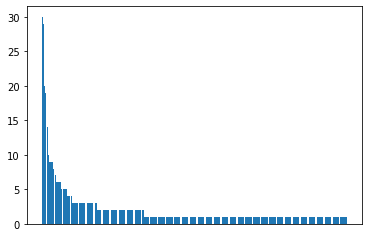

/tmp/ipykernel_8780/2876694636.py:8: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  plt.xticks([], [])


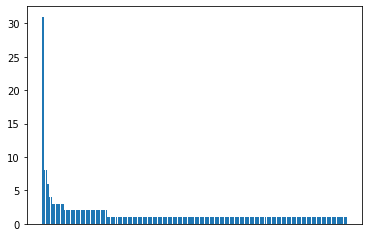

In [122]:
import matplotlib.pyplot as plt

plt.bar(*zip(*narrative.items()))
plt.xticks([], [])
plt.show()

plt.bar(*zip(*description.items()))
plt.xticks([], [])
plt.show()

In [123]:
to_remove_word = []

for key in narrative:
    if narrative[key] > 10:
        to_remove_word.append(key)

for key in description:
    if description[key] > 10:
        to_remove_word.append(key)


In [124]:
print(to_remove_word)

['study', 'covid19', 'look', 'seek', 'include', 'information', 'virus', 'covid19']


In [125]:
from my_utils import reduce_queries
resized_queries = reduce_queries(queries)

    ## Query Reduction

In [126]:
dataset = ir_datasets.load("cord19/trec-covid")
queries = pd.DataFrame(dataset.queries_iter())
queries = preprocess_queries(queries, augemented=False)
queries = reduce_queries(queries)
display(queries.head(5))

pq_title = queries[['query_id', 'title']]
pq_title = pq_title.rename(columns={'query_id':'qid', 'title':'query'})
display(pq_title.head(5))

pq_desc = queries[['query_id', 'description']]
pq_desc = pq_desc.rename(columns={'query_id':'qid', 'description':'query'})
display(pq_desc.head(5))

pq_narr = queries[['query_id', 'narrative']]
pq_narr = pq_narr.rename(columns={'query_id':'qid', 'narrative':'query'})
display(pq_narr.head(5))

  0%|          | 0/50 [00:00<?, ?it/s]

,query_id,title,description,narrative
0,1,coronavirus origin,origin,range sarscov2 origin evolution animal source first transmission human
1,2,coronavirus response weather change,coronavirus respond change weather,range sarscov2 viability different weatherclimate condition well relate transmission different climate condition
2,3,coronavirus immunity,sarscov2 infect people develop immunity cross protection possible,immunity develop due infection sarscov2 cross protection gain due infection coronavirus type
3,4,people die coronavirus,cause death,mechanism death
4,5,animal model covid19,drug active sarscov sarscov2 animal,paper describe result test drug bind spike protein drug animal model paper sarscov2 infection cell culture assay also relevant


,qid,query
0,1,coronavirus origin
1,2,coronavirus response weather change
2,3,coronavirus immunity
3,4,people die coronavirus
4,5,animal model covid19


,qid,query
0,1,origin
1,2,coronavirus respond change weather
2,3,sarscov2 infect people develop immunity cross protection possible
3,4,cause death
4,5,drug active sarscov sarscov2 animal


,qid,query
0,1,range sarscov2 origin evolution animal source first transmission human
1,2,range sarscov2 viability different weatherclimate condition well relate transmission different climate condition
2,3,immunity develop due infection sarscov2 cross protection gain due infection coronavirus type
3,4,mechanism death
4,5,paper describe result test drug bind spike protein drug animal model paper sarscov2 infection cell culture assay also relevant


In [127]:
# en_docs {title, abstract, both} with query_description
exp4 = expirement(index_en_docs_title, pq_desc, qrels)
display(exp4)

exp5 = expirement(index_en_docs_abstract, pq_desc, qrels)
display(exp5)

exp6 = expirement(index_en_docs_both, pq_desc, qrels)
display(exp6)

# en_docs {title, abstract, both} with query_narrative
exp7 = expirement(index_en_docs_title, pq_narr, qrels)
display(exp7)

exp8 = expirement(index_en_docs_abstract, pq_narr, qrels)
display(exp8)

exp9 = expirement(index_en_docs_both, pq_narr, qrels)
display(exp9)

,name,P@5,P@10,nDCG@10,RR(rel=2)
0,TF_IDF,0.648,0.552,0.540841,0.672157
1,BM25,0.648,0.550,0.536981,0.669379
2,DirichletLM,0.452,0.438,0.406525,0.498696


,name,P@5,P@10,nDCG@10,RR(rel=2)
0,TF_IDF,0.736,0.696,0.638426,0.753717
1,BM25,0.736,0.690,0.628885,0.713130
2,DirichletLM,0.692,0.660,0.606479,0.677555


,name,P@5,P@10,nDCG@10,RR(rel=2)
0,TF_IDF,0.636,0.564,0.549397,0.689585
1,BM25,0.648,0.566,0.552331,0.696808
2,DirichletLM,0.496,0.454,0.420075,0.505550


,name,P@5,P@10,nDCG@10,RR(rel=2)
0,TF_IDF,0.472,0.444,0.408609,0.503428
1,BM25,0.484,0.452,0.417505,0.522439
2,DirichletLM,0.284,0.262,0.246613,0.388369


,name,P@5,P@10,nDCG@10,RR(rel=2)
0,TF_IDF,0.588,0.582,0.513330,0.557399
1,BM25,0.584,0.572,0.505319,0.564145
2,DirichletLM,0.440,0.460,0.404459,0.521294


,name,P@5,P@10,nDCG@10,RR(rel=2)
0,TF_IDF,0.504,0.474,0.438155,0.562505
1,BM25,0.516,0.470,0.436144,0.561857
2,DirichletLM,0.292,0.238,0.233239,0.375783


In [128]:
# docs {title, abstract, both} with query_description
exp4 = expirement(index_docs_title, pq_desc, qrels)
display(exp4)

exp5 = expirement(index_docs_abstract, pq_desc, qrels)
display(exp5)

exp6 = expirement(index_docs_both, pq_desc, qrels)
display(exp6)

# docs {title, abstract, both} with query_narrative
exp7 = expirement(index_docs_title, pq_narr, qrels)
display(exp7)

exp8 = expirement(index_docs_abstract, pq_narr, qrels)
display(exp8)

exp9 = expirement(index_docs_both, pq_narr, qrels)
display(exp9)

,name,P@5,P@10,nDCG@10,RR(rel=2)
0,TF_IDF,0.652,0.550,0.542303,0.685133
1,BM25,0.648,0.550,0.539480,0.682356
2,DirichletLM,0.452,0.436,0.405446,0.498523


,name,P@5,P@10,nDCG@10,RR(rel=2)
0,TF_IDF,0.736,0.694,0.637153,0.753939
1,BM25,0.740,0.692,0.630433,0.713130
2,DirichletLM,0.692,0.658,0.605315,0.677555


,name,P@5,P@10,nDCG@10,RR(rel=2)
0,TF_IDF,0.632,0.564,0.548763,0.689308
1,BM25,0.648,0.566,0.552112,0.696530
2,DirichletLM,0.496,0.454,0.420075,0.505641


,name,P@5,P@10,nDCG@10,RR(rel=2)
0,TF_IDF,0.468,0.444,0.408597,0.504494
1,BM25,0.484,0.452,0.418066,0.522361
2,DirichletLM,0.300,0.262,0.250805,0.393369


,name,P@5,P@10,nDCG@10,RR(rel=2)
0,TF_IDF,0.592,0.582,0.512907,0.557399
1,BM25,0.584,0.574,0.506481,0.564145
2,DirichletLM,0.436,0.462,0.404089,0.519748


,name,P@5,P@10,nDCG@10,RR(rel=2)
0,TF_IDF,0.500,0.474,0.437987,0.562506
1,BM25,0.512,0.470,0.436155,0.561862
2,DirichletLM,0.292,0.238,0.233879,0.375757


## Pairwise Similarity of Queries
 - TF-IDF
 - DOC2VEC

Write a function that measures the pairwise similarity of the provided 
queries. Create a list of similar queries and a word-cloud of their qids.

In [129]:
%%capture
%pip install gensim

import pandas as pd
import numpy as np
import wordcloud

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram
from gensim.models.doc2vec import Doc2Vec, TaggedDocument


def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

def compute_freqs(queries, labels):
    freqs = {}
    for i in range(max(labels)):
        # print(f"cluster {i:2} {queries.loc[labels==i]['title'].values}")

        similar_queries = queries.loc[labels==i]['query_id'].values
        for qid in similar_queries:
            freqs[qid] = len(similar_queries)

    return freqs

def print_clustered_queries(queries, labels):
    for i in range(max(labels)):
        print(f"cluster {i:2} {queries.loc[labels==i]['description'].values}")

In [130]:
if AUGMENTED:
    queries = pd.read_pickle('./data/queries_processed_aug.pkl')
else:
    queries = pd.read_pickle('./data/queries_processed.pkl')

vectorizer = TfidfVectorizer()
vectors = vectorizer.fit_transform(queries['description']).toarray()

cluster = AgglomerativeClustering(n_clusters=None, affinity='cosine', linkage='average', distance_threshold=0.9)
labels = cluster.fit_predict(vectors)

print_clustered_queries(queries, labels)

cluster  0 ['clinical coscovid trial randomize available authorized coronavirus 2019'
 'new york public health datasets dataset available authorized related relate covid19 coronavirus'
 'health public outcome outcomes child adolescent contract familys covid19 coronavirus']
cluster  1 ['cause provokes death deaths covid19 coronavirus'
 'lack limited test testing availability limited lead cause underreporting cfp true undercounting incidence prevalence covid19 coronavirus']
cluster  2 ['serological serology test testing detect detection antibody igg coronavirus 2019'
 'vaccine adjuvanted candidate ace2based test testing covid19 coronavirus'
 'know confronts mrna padi6 vaccine adjuvanted sarscov2 covid19 virus viral']
cluster  3 ['covid19 coronavirus pandemic outbreak impact effect violence genderbased society snacc include included violent suddenunexpected crime burglary'
 'covid19 coronavirus pandemic outbreak impact effect mental psychological health public'
 'benefit harm risk suscept

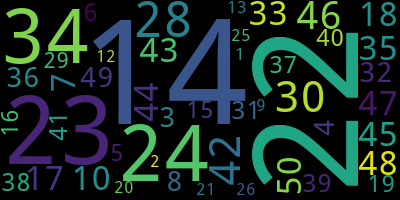

In [131]:
wordcloud.WordCloud().fit_words(compute_freqs(queries, labels)).to_image()

In [132]:
tagged_data = [TaggedDocument(words=doc.split(), tags=[str(i)]) for i, doc in enumerate(queries['description'])]
doc_model = Doc2Vec(tagged_data, window=5, seed=1)
d2v_doc_embeddings = np.array([doc_model.infer_vector(doc.split()) for doc in queries['description']])
print(d2v_doc_embeddings.shape)

cluster = AgglomerativeClustering(n_clusters=None, affinity='cosine', linkage='average', distance_threshold=0.95)
labels = cluster.fit_predict(d2v_doc_embeddings)

print_clustered_queries(queries, labels)

(50, 100)
cluster  0 ['coronavirus 2019 respond ghdemphnet change forcing weather meteorological'
 'cause provokes death deaths covid19 coronavirus'
 'best good practice laryngology hospital tertiary home assistedliving maintain ensure quarantine isolation'
 'long short coronavirus 2019 live living outside outsidewuhan body fluids'
 'know confronts infected infect covid19 coronavirus asymptomatic symptomatic'
 'observed observe mutation d614g sarscov2 covid19 genome sequence often usually mutation d614g occur occurred']
cluster  1 ['drug repurposing active dayuanyin sarscov sars sarscov2 covid19 animal domesticate study prospective'
 'patient hospitalize take action angiotensinconverting enzyme enzyme angiotensinconverting inhibitor inhibition ace angiotensin increase increased risk susceptibility covid19 coronavirus'
 'benefit harm risk susceptibility reopen reopening school closure midst grapple covid19 coronavirus pandemic outbreak']
cluster  2 ['evidence literature relate related c

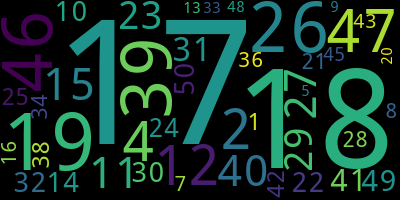

In [133]:
wordcloud.WordCloud().fit_words(compute_freqs(queries, labels)).to_image()

In [134]:
similar_queries = queries[labels == 0][['query_id', 'description']]
similar_queries = similar_queries.rename(columns={'query_id':'qid', 'description':'query'})
similar_queries

,qid,query
1,2,coronavirus 2019 respond ghdemphnet change forcing weather meteorological
3,4,cause provokes death deaths covid19 coronavirus
11,12,best good practice laryngology hospital tertiary home assistedliving maintain ensure quarantine isolation
14,15,long short coronavirus 2019 live living outside outsidewuhan body fluids
26,27,know confronts infected infect covid19 coronavirus asymptomatic symptomatic
39,40,observed observe mutation d614g sarscov2 covid19 genome sequence often usually mutation d614g occur occurred


In [135]:
tfidf = index_model(index_en_docs_abstract, model="TF_IDF")
bm25 = index_model(index_en_docs_abstract, model="BM25")
dirichlet_lm = index_model(index_en_docs_abstract, model="DirichletLM")

exp = pt.Experiment(
    [bm25],
    similar_queries,
    qrels,
    perquery=True,
    eval_metrics=[P@5, P@10, nDCG@10, RR(rel=2)],
    names=["BM25"]
)
display(exp)

,name,qid,measure,value
8,BM25,12,P@5,0.400000
9,BM25,12,P@10,0.200000
10,BM25,12,nDCG@10,0.220092
11,BM25,12,RR(rel=2),0.333333
12,BM25,15,P@5,0.400000
13,BM25,15,P@10,0.300000
14,BM25,15,nDCG@10,0.205901
15,BM25,15,RR(rel=2),0.200000
0,BM25,2,P@5,0.600000
1,BM25,2,P@10,0.700000


## Doc2Query

In [12]:
%%capture

!pip install --upgrade git+https://github.com/terrier-org/pyterrier.git#egg=python-terrier
!pip install --upgrade git+https://github.com/terrierteam/pyterrier_doc2query.git

In [13]:
%%capture
import os
if not os.path.exists("t5-base.zip"):
  !wget https://git.uwaterloo.ca/jimmylin/doc2query-data/raw/master/T5-passage/t5-base.zip
  !unzip t5-base.zip

In [14]:
from pyterrier_doc2query import Doc2Query
doc2query = Doc2Query(out_attr="text", batch_size=8)

ModuleNotFoundError: No module named 'pyterrier_doc2query'

In [ ]:
sample_doc = "protein proteins structure cryoelectron sarscov2 viral spike glycoprotein"
doc2query._doc2query([sample_doc, sample_doc])

In [ ]:
indexer = doc2query >> pt.DFIndexer("./indexes/en/title", remove_stopwords=False, overwrite=True)
indexer.setProperty("termpipelines", "")
index_ref = indexer.index(en_docs["abstract"], en_docs["docno"])

In [ ]:
bm25 = index_model(index_ref, model="BM25")

exp = pt.Experiment(
    [bm25],
    pq_title,
    qrels,
    eval_metrics=[P@5, P@10, nDCG@10, RR(rel=2)],
    names=["BM25"]
)
display(exp)